In [1]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from matplotlib.collections import LineCollection
from sympy import I, N, re, im, exp, sin, cos, sqrt, pi, eye
import numpy as np
import matplotlib.lines as mlines
from matplotlib.collections import LineCollection

#mpl.rcParams['path.simplify'] = True
#mpl.rcParams['path.simplify_threshold'] = 1.0

def min_max_scale(OldValue, OldMax, OldMin, NewMax, NewMin):
    return (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin

def add_annotation(ax, idx, lines, zdata, color):
    p1_x = lines[idx][1][0][0]
    p1_y = lines[idx][1][0][1]
    p1_z = zdata[idx]
    
    p2_x = lines[idx][1][1][0]
    p2_y = lines[idx][1][1][1]
    p2_z = zdata[idx]
    
    num = lines[idx][0]
    
    ax.text(p1_x, p1_y, p1_z,'%s(2)' % (num))
    ax.scatter(p1_x, p1_y, p1_z, color=color)
    
    ax.text(p2_x, p2_y, p2_z,'%s(3)' % (num))
    ax.scatter(p2_x, p2_y, p2_z, color=color)

def get_angle_n(x, base_n):
    if x == 1:
        return 0
    
    n = int(math.log(x, base_n))
    k = x - base_n**n
    return 2*np.pi + np.pi/2 - 2*np.pi*k/base_n**n    

def get_point(t, base_n):
    return rotate(get_angle_n(t, base_n))

    
def get_line_collection(n_points, base_p1, base_p2):
    lines = []
    for i in range(0, n_points):
        num = 2*i+1
        p_1=get_point(num, base_p1)
        p_2=get_point(num, base_p2)
        lines.append((num, (p_1, p_2)))
    return lines

def get_scaled_z(vals, log):
    zdata_log = [math.log(val, log) for val in vals]
    zdata_min = min(zdata_log)
    zdata_max = max(zdata_log)
    new_min = 0
    new_max = 1
    return [min_max_scale(x, zdata_max, zdata_min, new_max, new_min) for x in zdata_log]

def get_trisurf_x(lines):
    x_inner = [l[1][0][0] for l in lines]
    x_outer = [l[1][1][0] for l in lines]
    return np.concatenate([x_inner, x_outer])

def get_trisurf_y(lines):
    y_inner = [l[1][0][1] for l in lines]
    y_outer = [l[1][1][1] for l in lines]
    return np.concatenate([y_inner, y_outer])
    
def get_triangles(n_points):
    triangles = []
    for i in range(0, n_points//2 - 1):
        triangles.append([i, i + 1, n_points + i])
        triangles.append([n_points + i + 1, n_points + i, i + 1])
    return triangles
    
def add_annotation(ax, idx, xdata, zdata, ydata):
    ax.text(xdata[idx]+0.1, ydata[idx], zdata[idx],'x: %s\ny: %s\nz: %s\nn: %s' % (xdata[idx], ydata[idx], zdata[idx], idx))
    ax.scatter(xdata[idx], ydata[idx], zdata[idx])
    
def get_line_intersections(n_points, base_p1, base_p2, log):
    lines = get_line_collection(n_points, base_p1, base_p2)
    intersections = []

    for i in range(0, len(lines) - 1):
        line1 = LineString([(lines[i][1][0][0], lines[i][1][0][1]), (lines[i][1][1][0], lines[i][1][1][1])])
        line2 = LineString([(lines[i+1][1][0][0], lines[i+1][1][0][1]), (lines[i+1][1][1][0], lines[i+1][1][1][1])])
        mean_num = (lines[i][0] + lines[i+1][0])/2
        intersections.append((mean_num, line1.intersection(line2)))
        
    return intersections

def rotate(t):
    #rotate unit vector [0, 1] by "t"
    x = math.sin(t)
    y = math.cos(t)
    return (x, y)

def get_angle_2(x):
    if x == 1:
        return 0
    
    n = int(math.log2(x))
    k = x - 2**n
    return 2*np.pi + np.pi/2 - 2*np.pi*k/2**n

def get_angle_3(x):
    if x == 1:
        return 0
    
    n = int(math.log(x, 3))
    k = x - 3**n
    return 2*np.pi + np.pi/2 - 2*np.pi*k/3**n

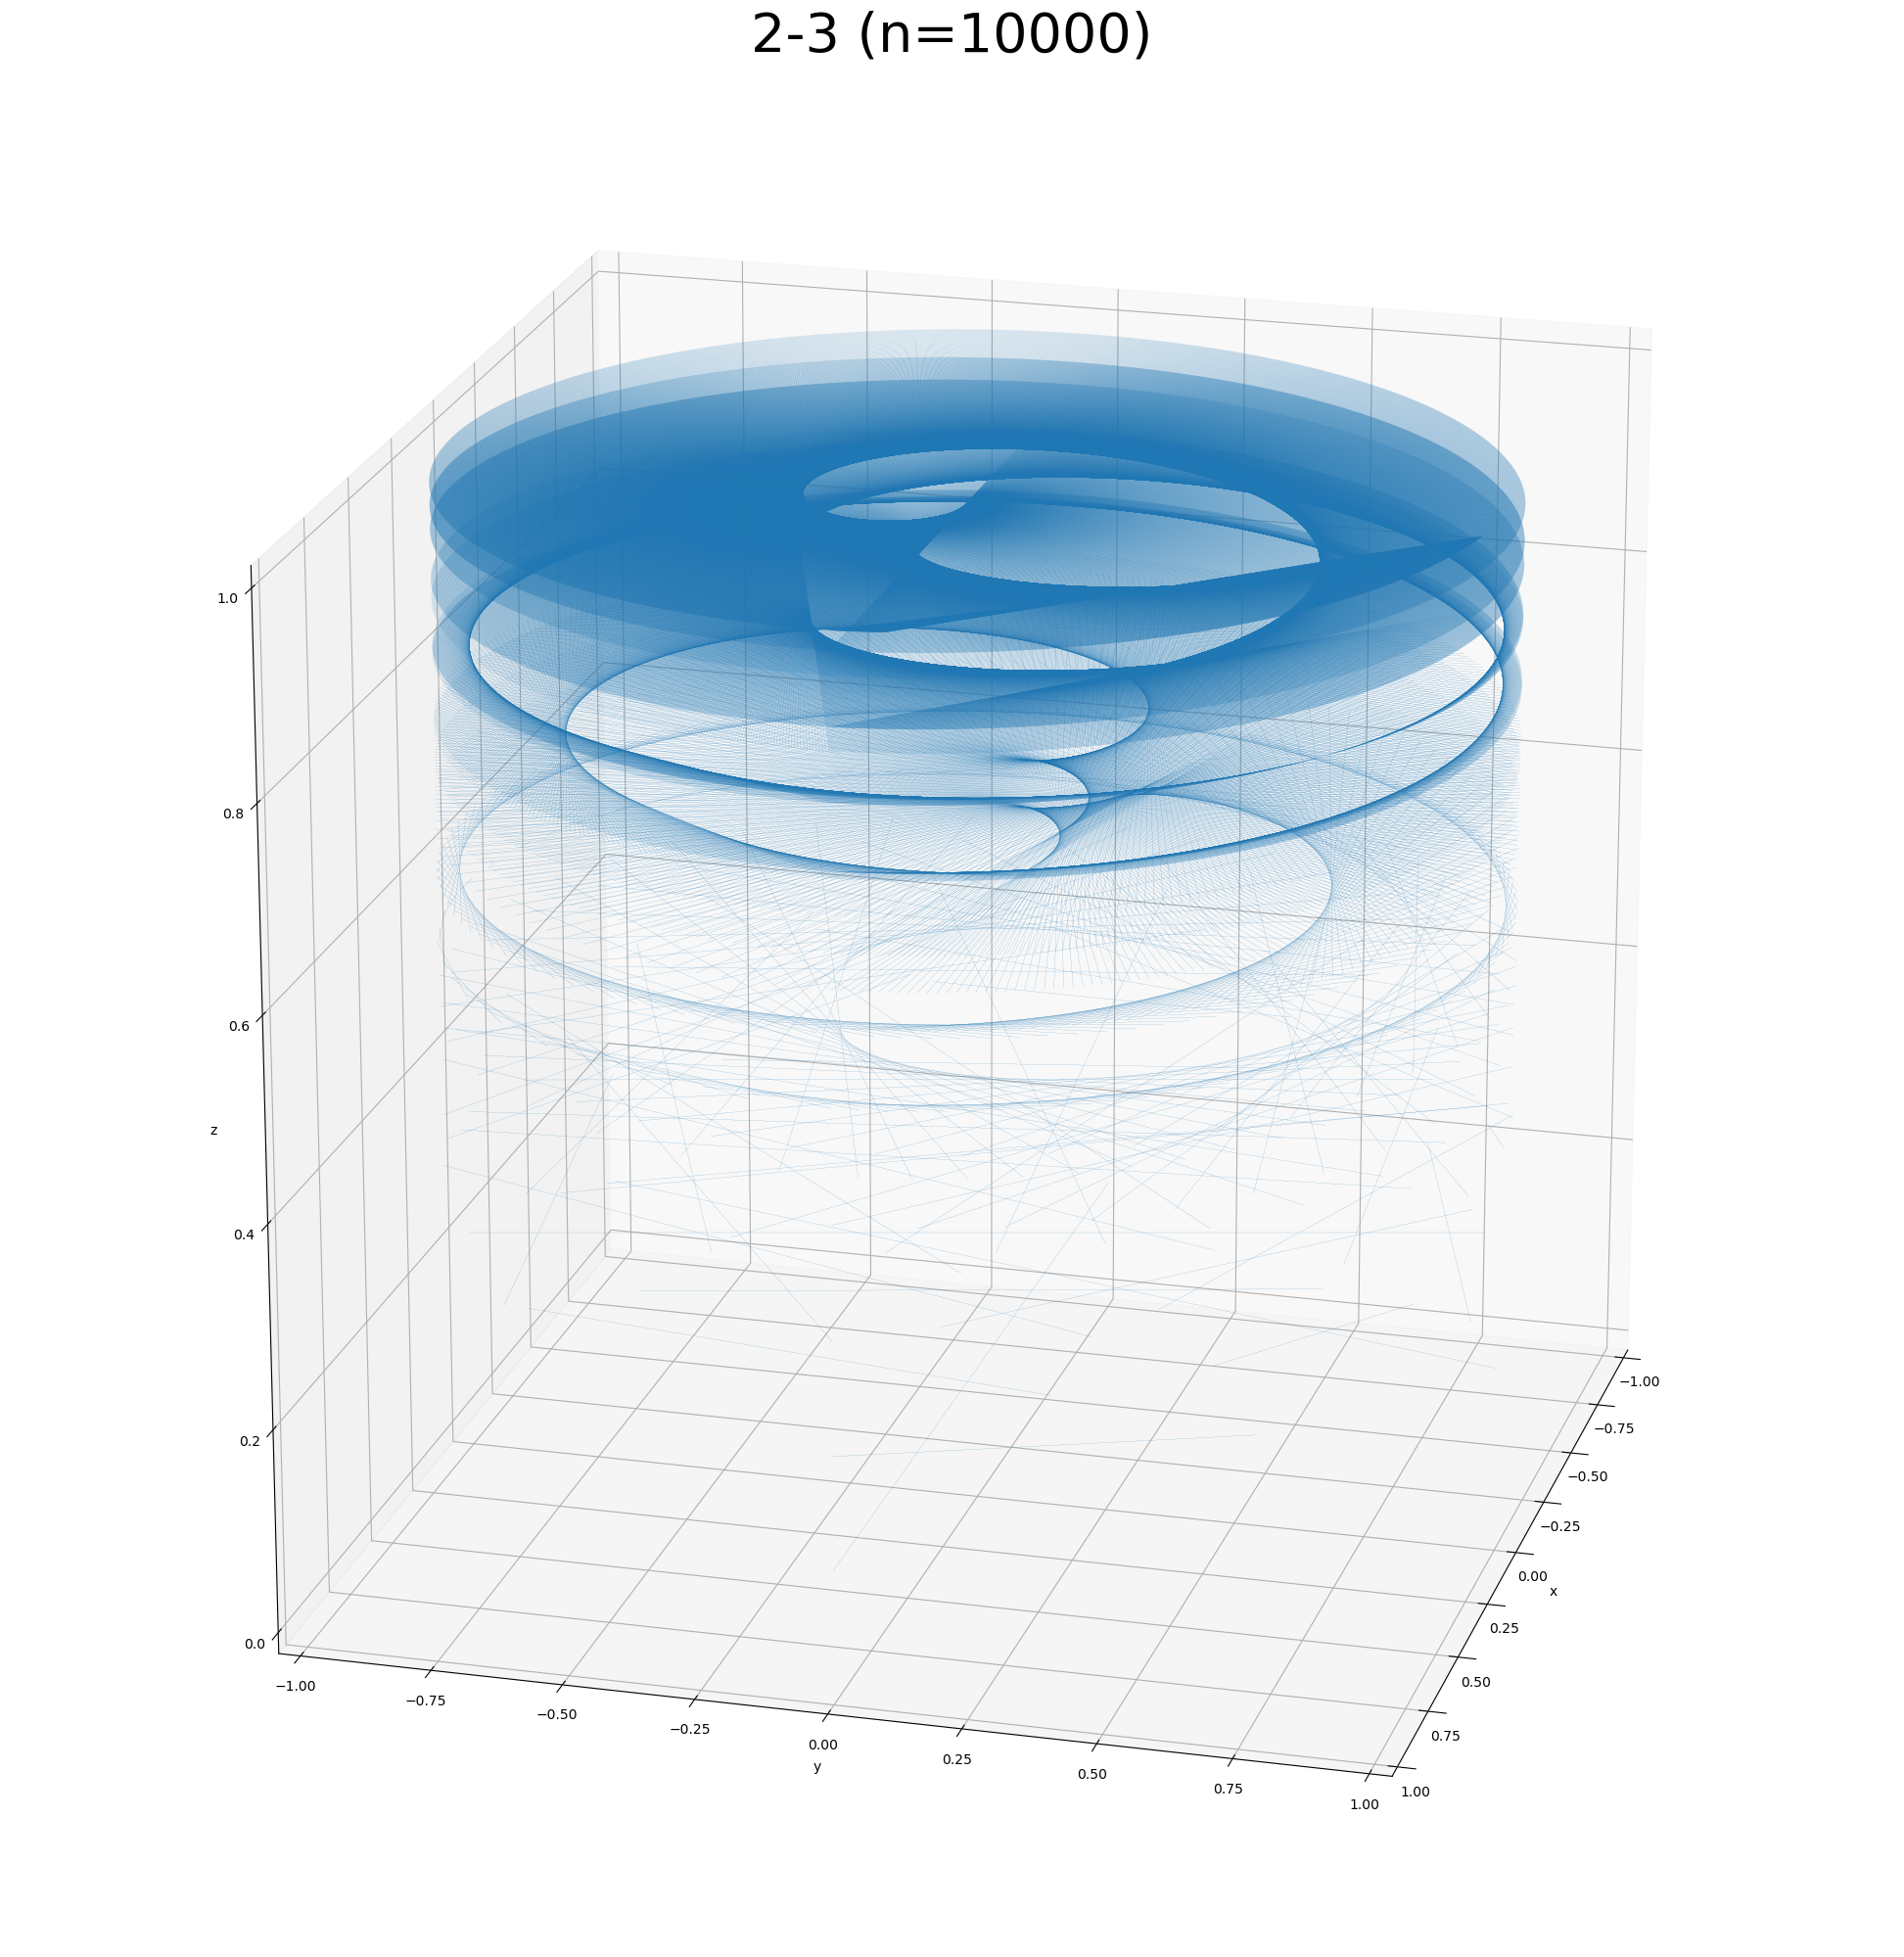

In [2]:
n_points = 10_000

def create_line_collection_plot(ax, n_points, base_n, base_m, log):
    lines = get_line_collection(n_points, base_n, base_m)
    zdata_scaled = get_scaled_z([line[0] for line in lines], log)

    lc = LineCollection([l[1] for l in lines], lw=0.1)

    ax.set_title('%d-%d (n=%s)' % (base_n, base_m, n_points), fontsize=40)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(0, 1)
    ax.set_box_aspect(aspect = (1,1,1))
    ax.add_collection3d(lc, zs=zdata_scaled)
    ax.view_init(elev=20, azim=15, roll=0)
    
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(projection='3d')

create_line_collection_plot(ax, n_points, 2, 3, 6)

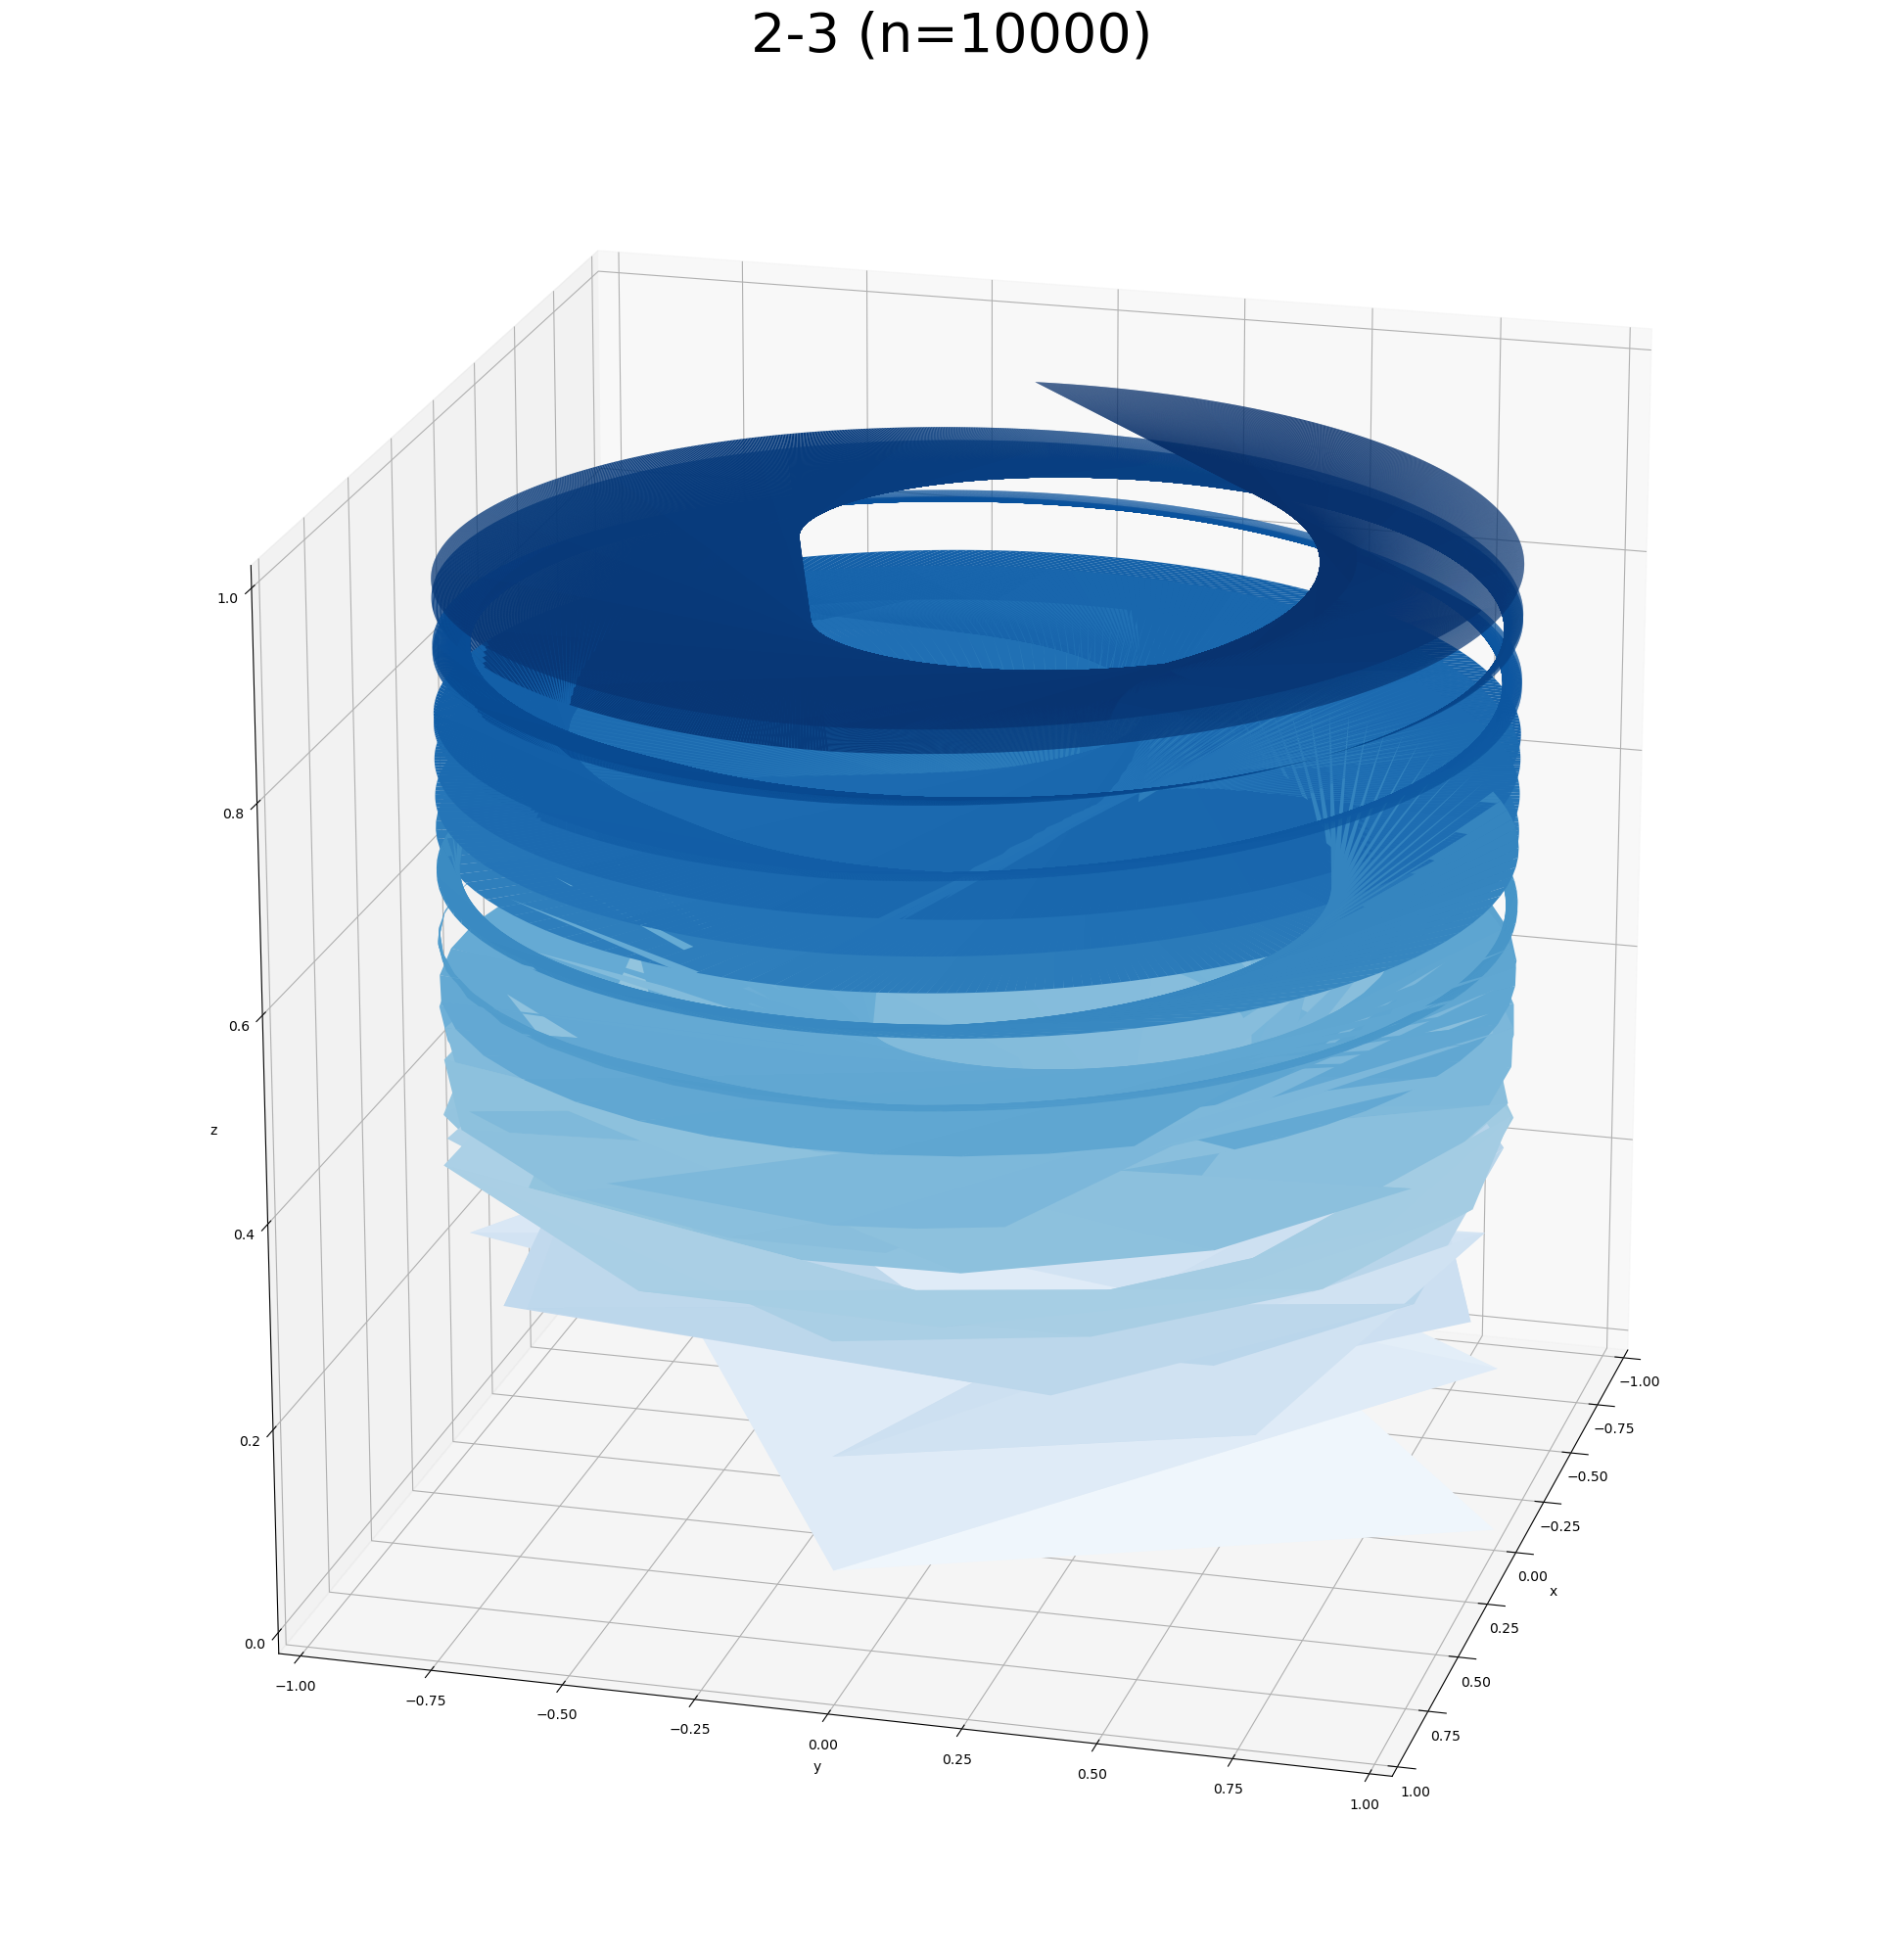

In [3]:
n_points = 10_000


def create_trisurf_plot(ax, n_points, base_n, base_m, log):
    lines = get_line_collection(n_points, base_n, base_m)
    zdata_scaled = get_scaled_z([line[0] for line in lines], log)

    xdata = get_trisurf_x(lines)
    ydata = get_trisurf_y(lines)
    triangles = get_triangles(n_points)

    lc = LineCollection([l[1] for l in lines], lw=0.05)

    ax.set_title('%d-%d (n=%s)' % (base_n, base_m, n_points), fontsize=40)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(0, 1)
    ax.set_box_aspect(aspect = (1,1,1))
    ax.plot_trisurf(xdata, ydata, np.concatenate([zdata_scaled, zdata_scaled]), triangles=triangles, cmap=plt.cm.Blues)
    ax.view_init(elev=20, azim=15, roll=0)

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(projection='3d')

create_trisurf_plot(ax, n_points, 2, 3, 6)
    

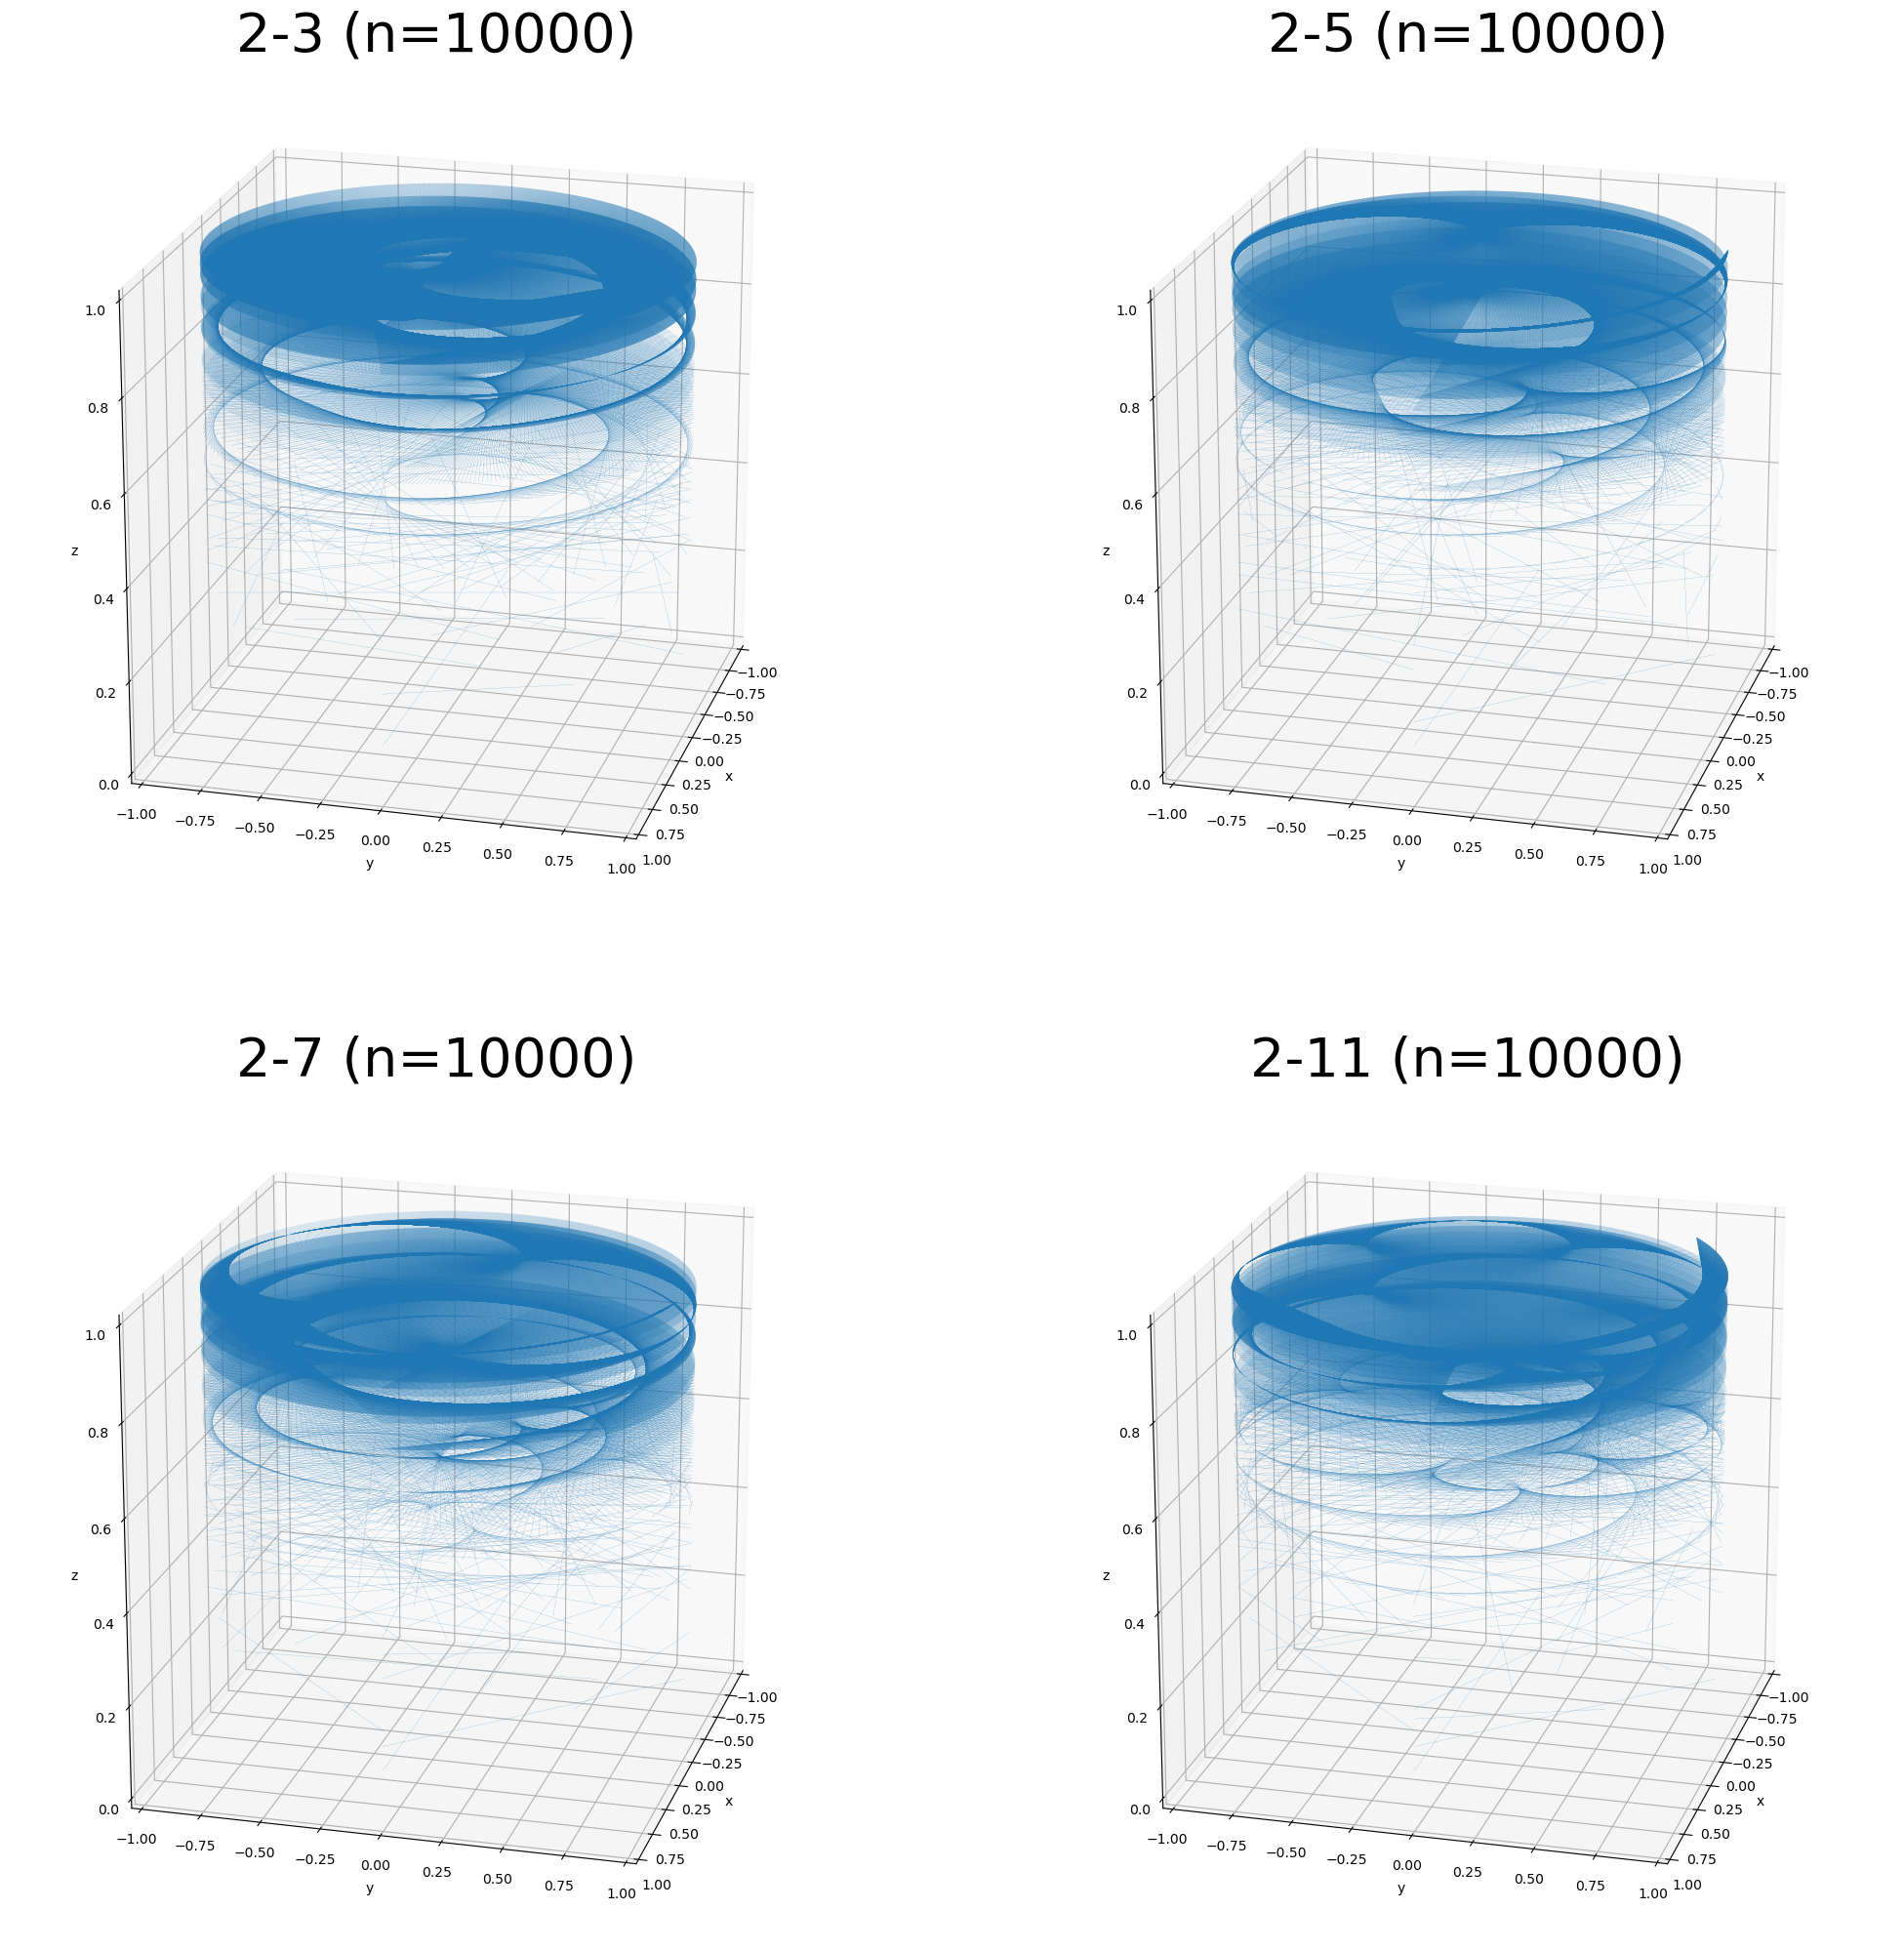

In [4]:
fig = plt.figure(figsize=(25,25))

ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

n_points = 10_000

create_line_collection_plot(ax1, n_points, 2, 3, 6)
create_line_collection_plot(ax2, n_points, 2, 5, 6)
create_line_collection_plot(ax3, n_points, 2, 7, 6)
create_line_collection_plot(ax4, n_points, 2, 11, 6)


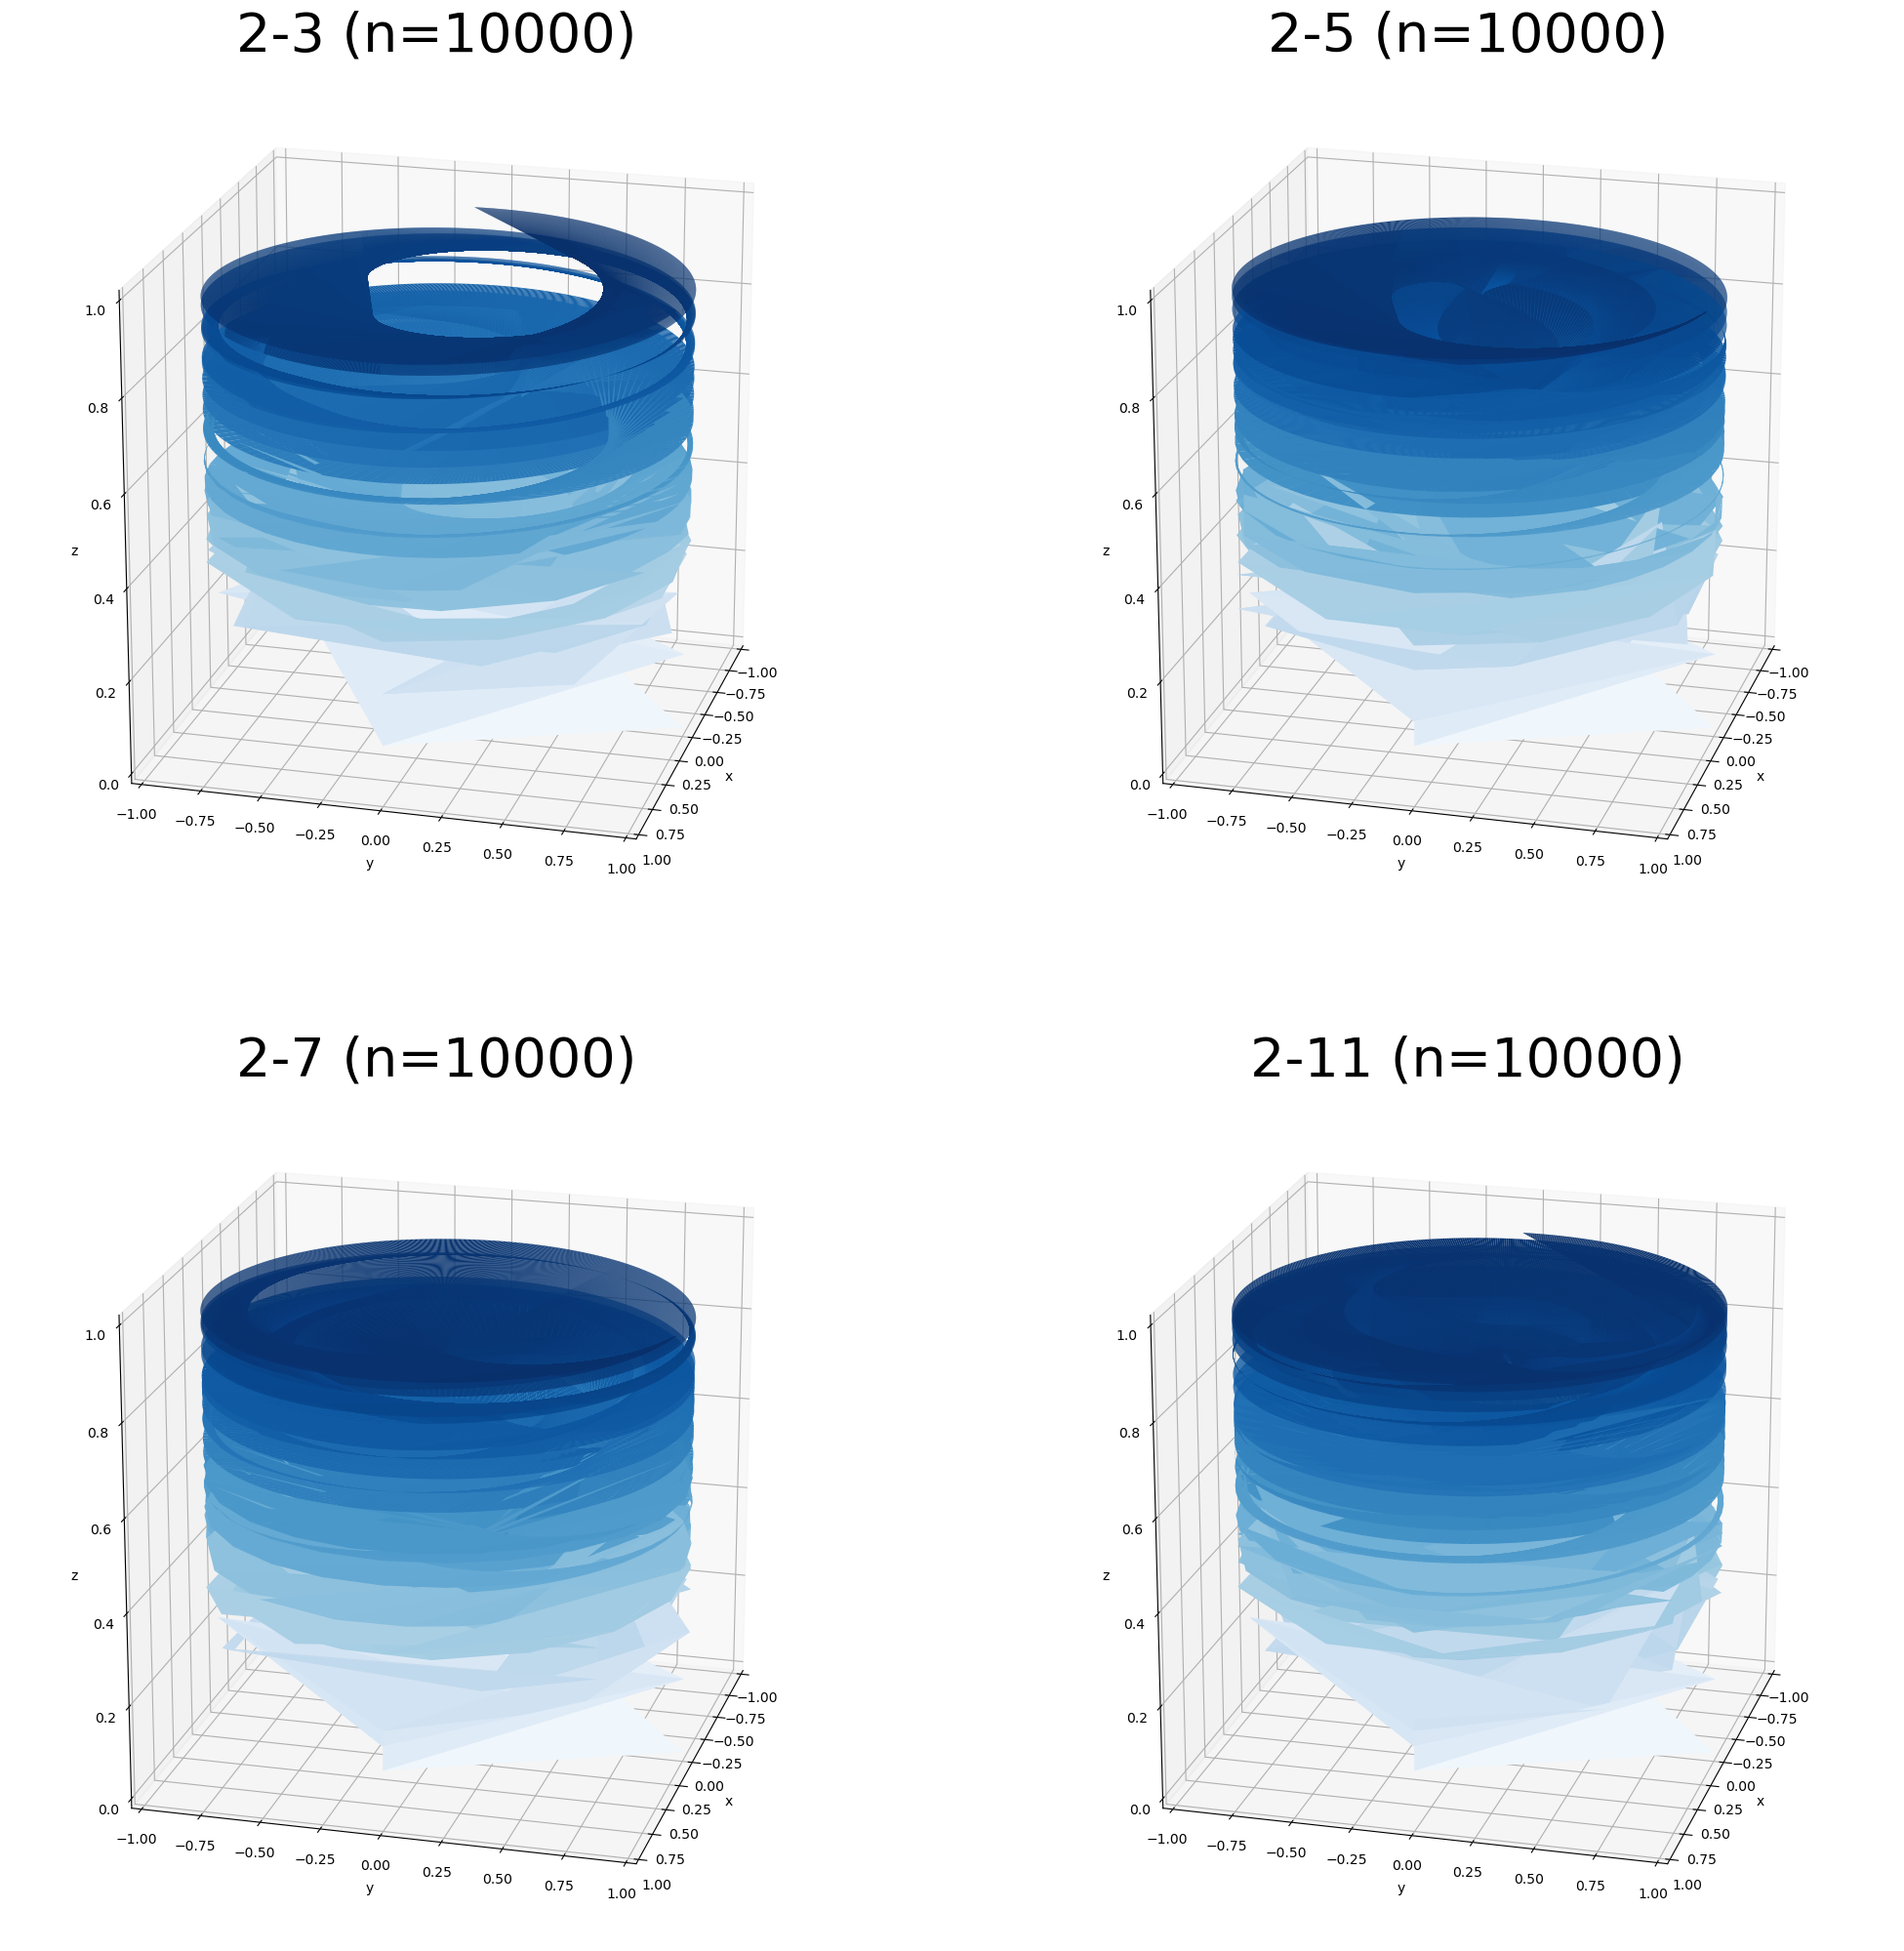

In [5]:
fig = plt.figure(figsize=(25,25))

ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

n_points = 10_000

create_trisurf_plot(ax1, n_points, 2, 3, 6)
create_trisurf_plot(ax2, n_points, 2, 5, 6)
create_trisurf_plot(ax3, n_points, 2, 7, 6)
create_trisurf_plot(ax4, n_points, 2, 11, 6)


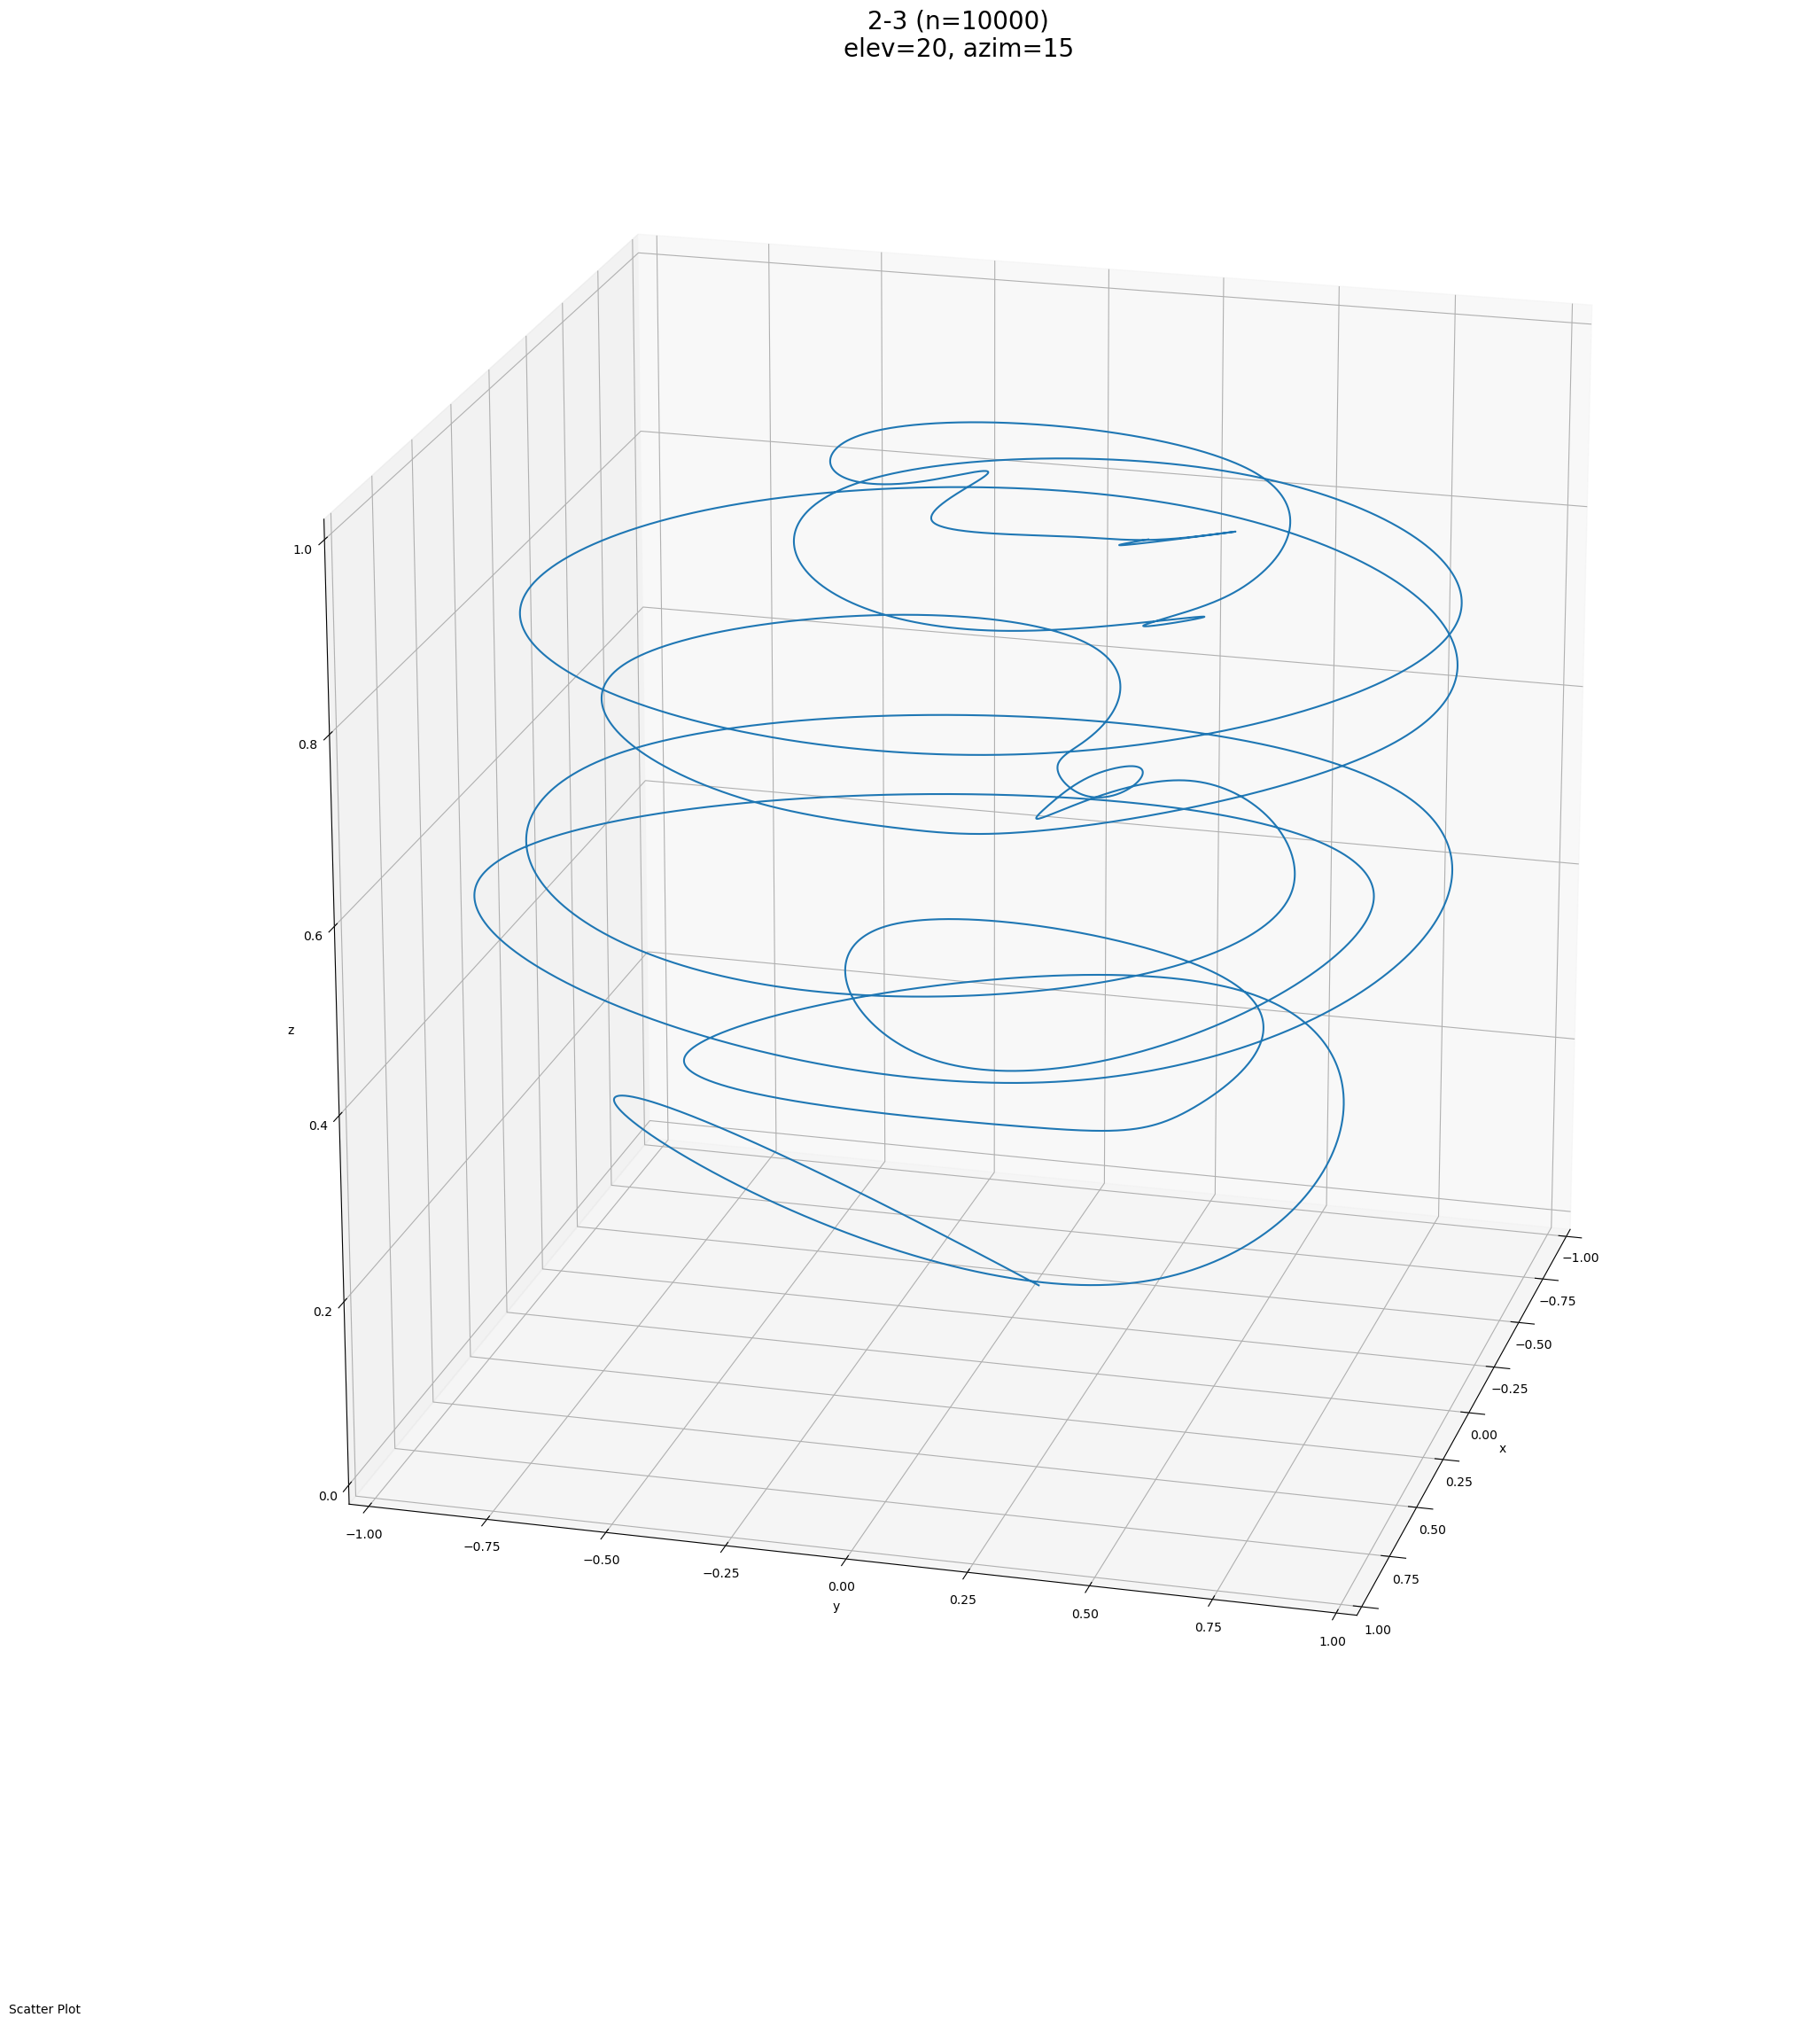

In [6]:
import shapely
import numpy as np
from shapely.geometry import LineString, Point
from scipy import interpolate
  
n_points = 10_000

def create_intersection_plot(ax, n_points, base_n, base_m, log, elev, azim, roll):
    intersections = get_line_intersections(n_points, base_n, base_m, log)
    intersection_points = [intersections[i] for i in range(0, len(intersections)) if type(intersections[i][1]) is Point][::]
    x_data = [p[1].x for p in intersection_points]
    y_data = [p[1].y for p in intersection_points]
    z_data = get_scaled_z([p[0] for p in intersection_points], log)
    
    tck, u = interpolate.splprep([x_data,y_data,z_data], s=3)
    x_knots, y_knots, z_knots = interpolate.splev(tck[0], tck)
    u_fine = np.linspace(0,1,n_points)
    x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)
    
    ax.set_title('%d-%d (n=%s)\nelev=%s, azim=%s' % (base_n, base_m, n_points, elev, azim), fontsize=20)     
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(0, 1)
    ax.set_box_aspect(aspect = (1,1,1))
    ax.plot(x_fine, y_fine, zs=z_fine, zdir='z')
    ax.view_init(elev=elev, azim=azim, roll=roll)

fig = plt.figure(figsize=(25,25))
fig.text(.1, .0001,"Scatter Plot", ha='center')
ax = fig.add_subplot(projection='3d')

create_intersection_plot(ax, n_points, 2, 3, 6, elev=20, azim=15, roll=0)


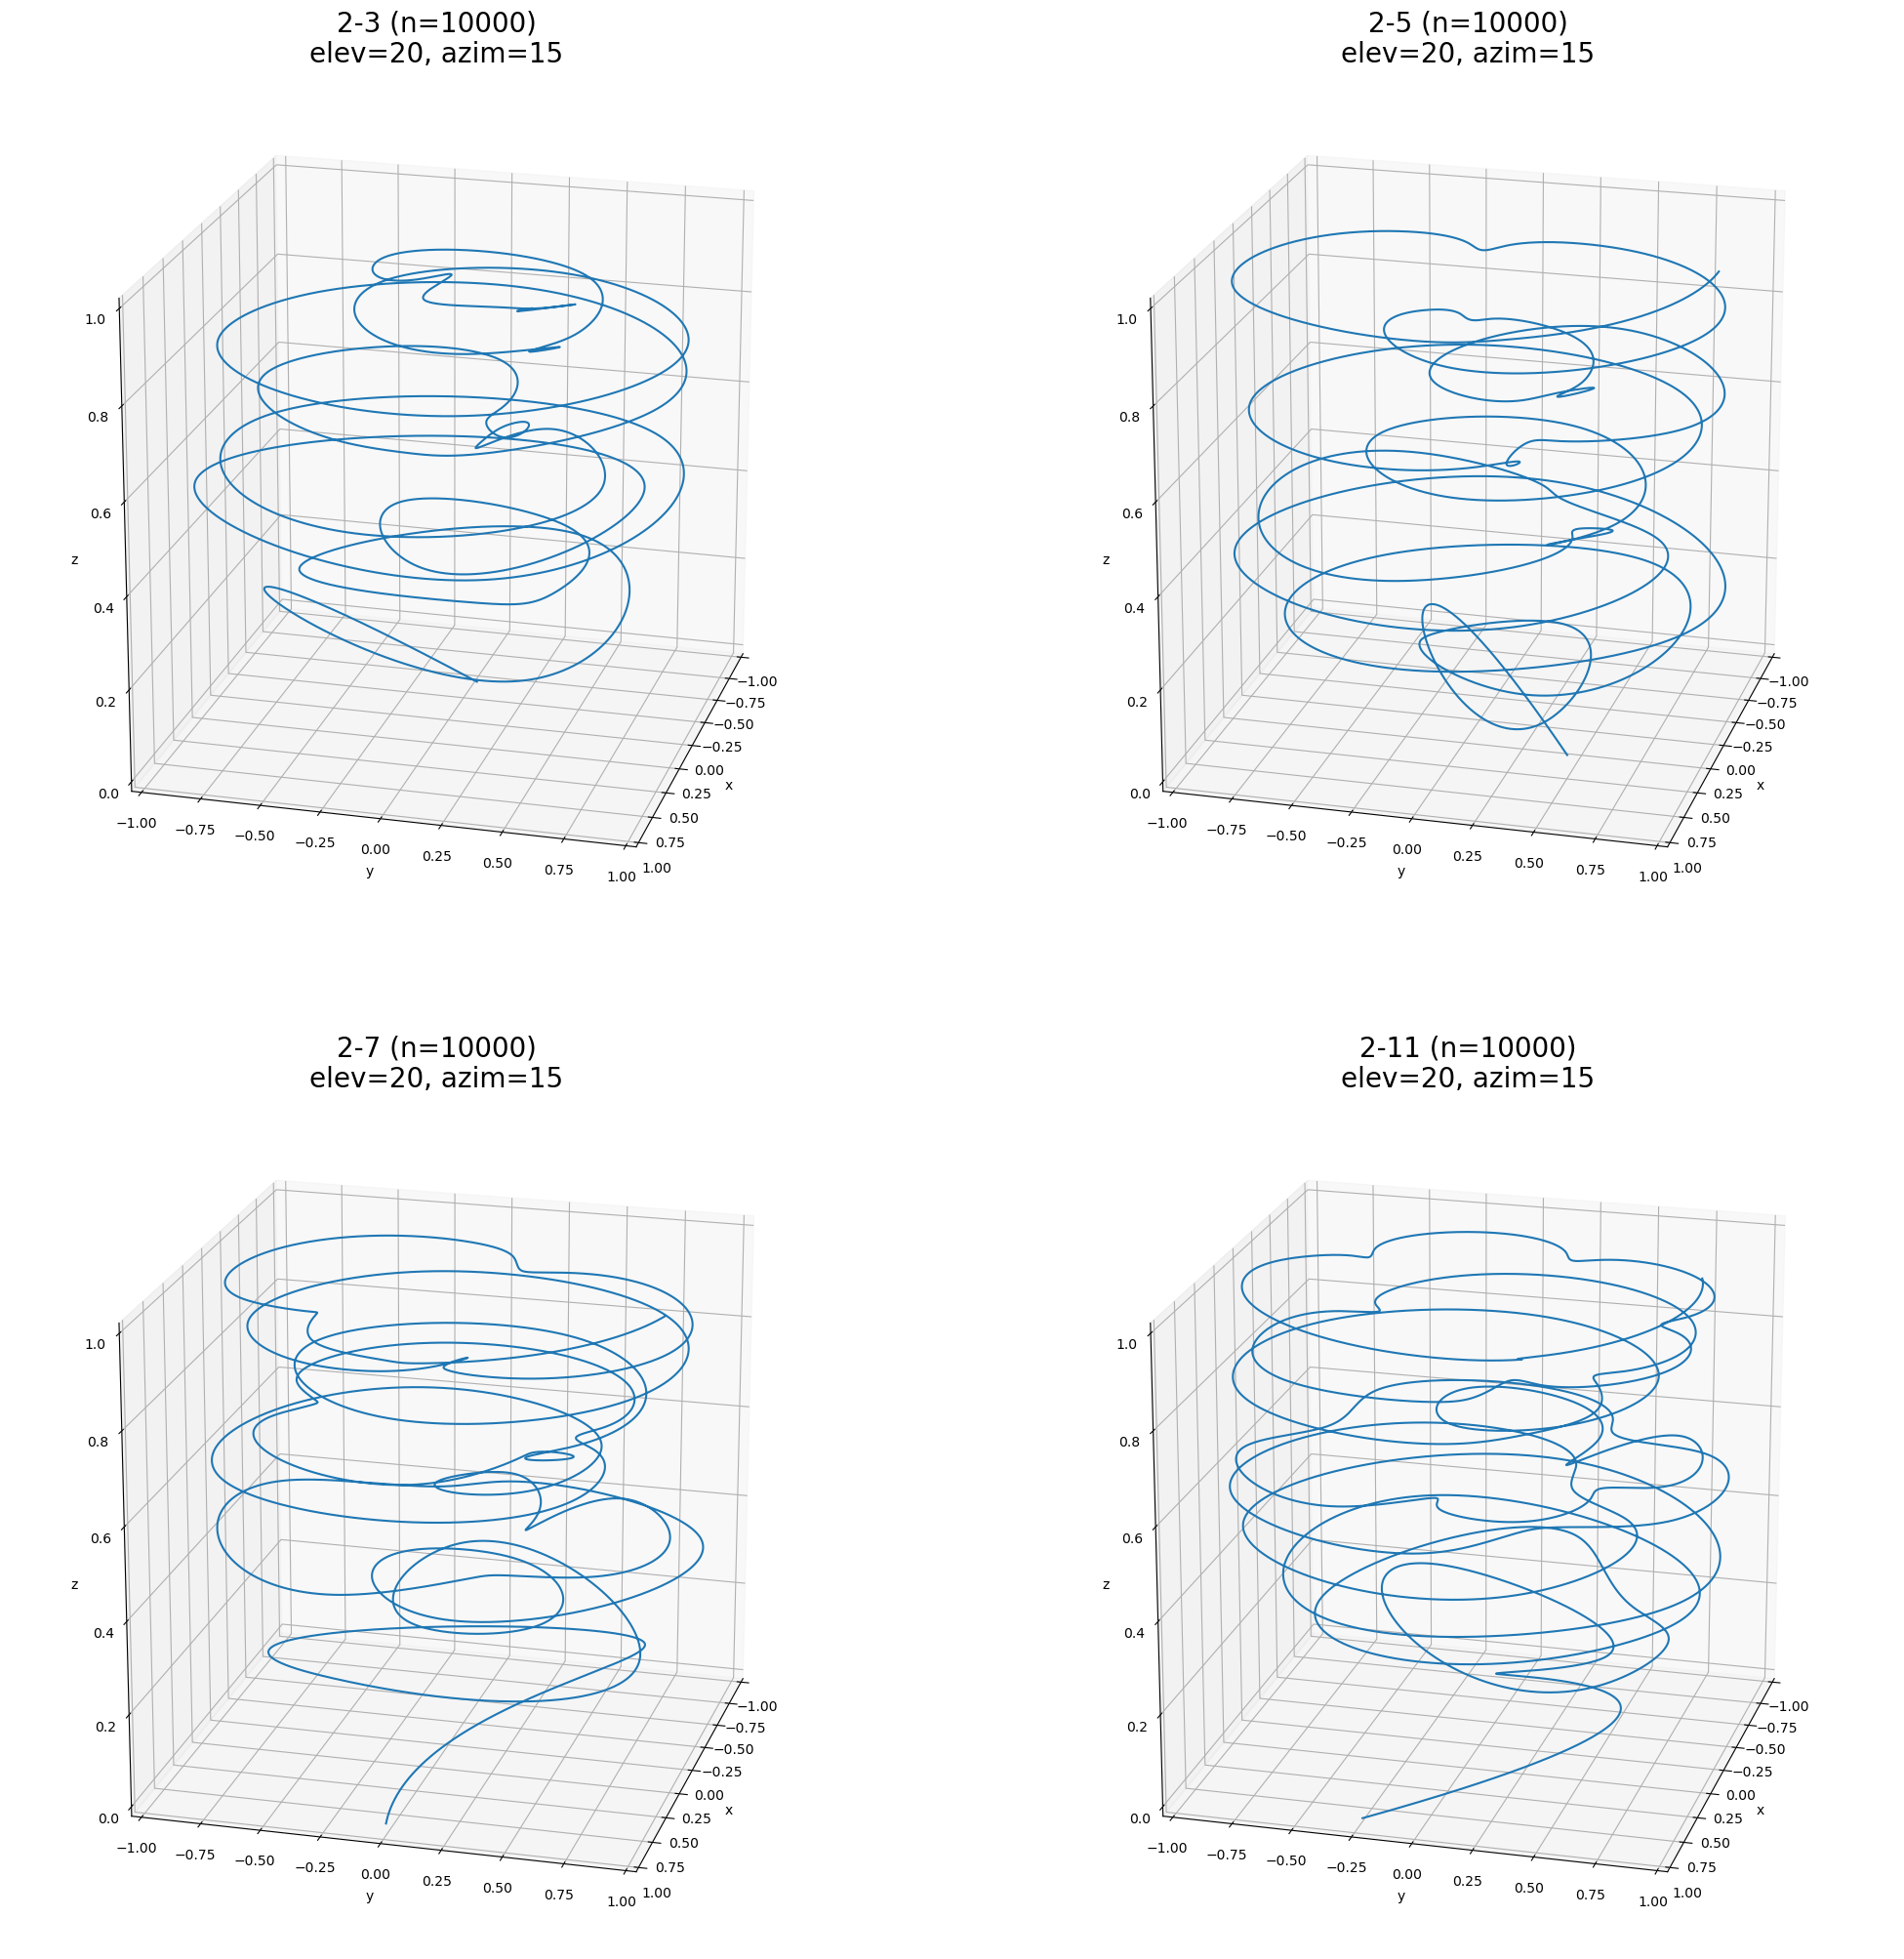

In [7]:
fig = plt.figure(figsize=(25,25))

elev=20
azim=15
roll=0

ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

n_points = 10_000

create_intersection_plot(ax1, n_points, 2, 3, 6, elev=elev, azim=azim, roll=roll)
create_intersection_plot(ax2, n_points, 2, 5, 6, elev=elev, azim=azim, roll=roll)
create_intersection_plot(ax3, n_points, 2, 7, 6, elev=elev, azim=azim, roll=roll)
create_intersection_plot(ax4, n_points, 2, 11, 6, elev=elev, azim=azim, roll=roll)

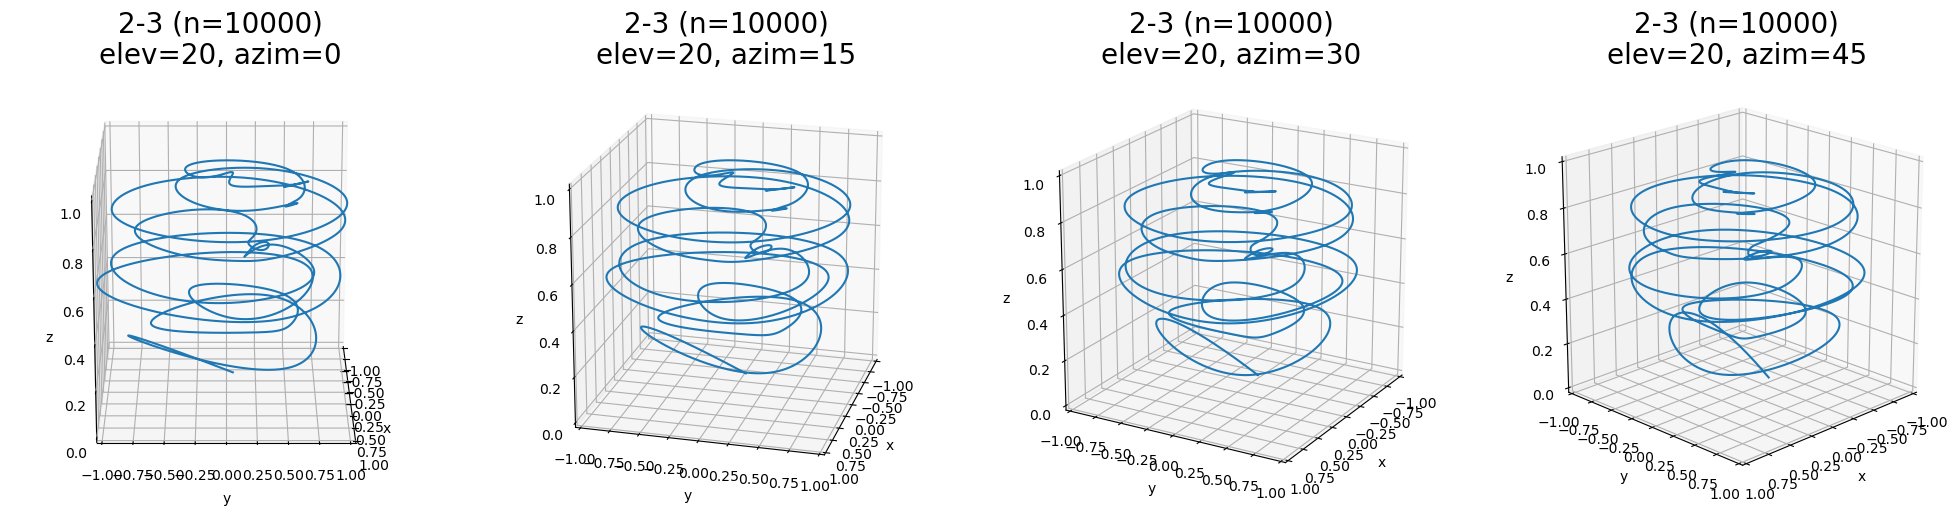

In [8]:
fig = plt.figure(figsize=(25,25))
azim_arr = [0, 15, 30, 45]
elev=20 
roll=0

ax1 = fig.add_subplot(141, projection='3d')
ax2 = fig.add_subplot(142, projection='3d')
ax3 = fig.add_subplot(143, projection='3d')
ax4 = fig.add_subplot(144, projection='3d')

n_points = 10_000

create_intersection_plot(ax1, n_points, 2, 3, 6, elev=elev, azim=azim_arr[0], roll=roll)
create_intersection_plot(ax2, n_points, 2, 3, 6, elev=elev, azim=azim_arr[1], roll=roll)
create_intersection_plot(ax3, n_points, 2, 3, 6, elev=elev, azim=azim_arr[2], roll=roll)
create_intersection_plot(ax4, n_points, 2, 3, 6, elev=elev, azim=azim_arr[3], roll=roll)


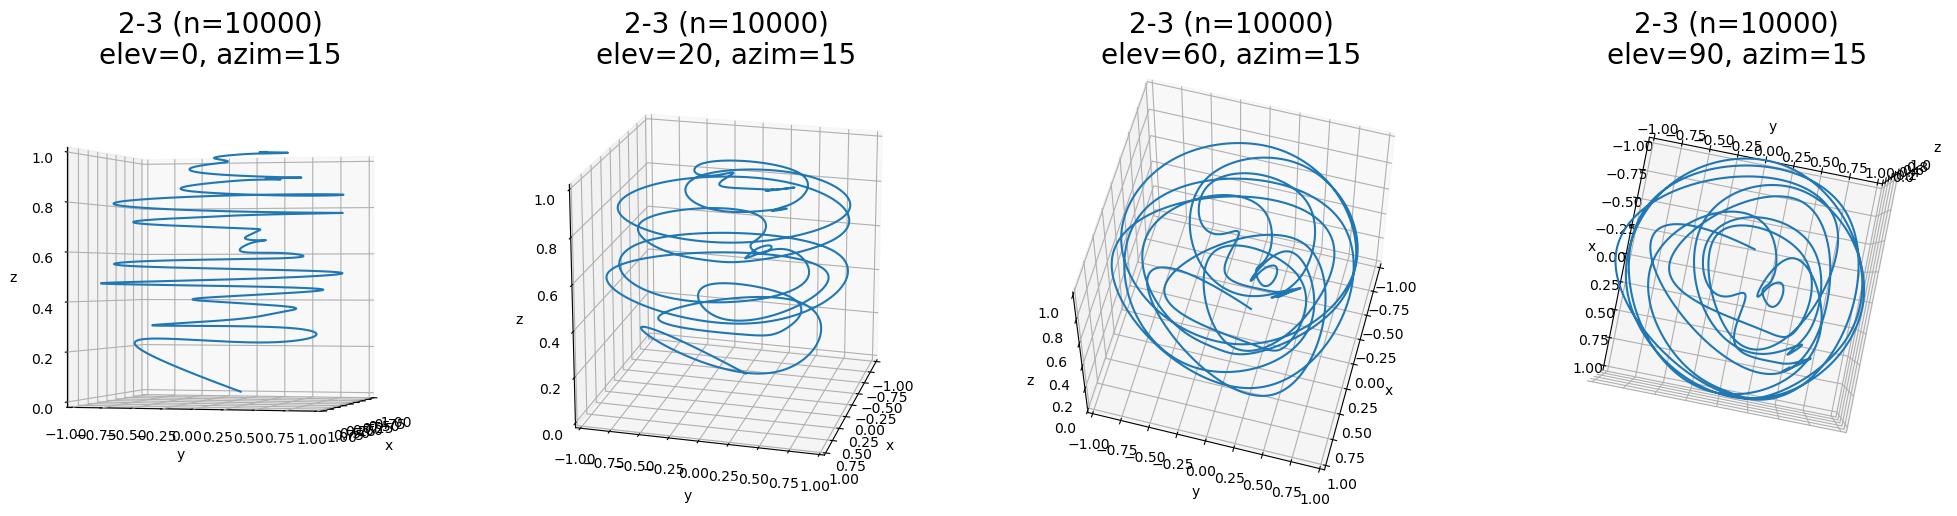

In [9]:
fig = plt.figure(figsize=(25,25))
azim = 15
elev_arr = [0, 20, 60, 90]
roll=0

ax1 = fig.add_subplot(141, projection='3d')
ax2 = fig.add_subplot(142, projection='3d')
ax3 = fig.add_subplot(143, projection='3d')
ax4 = fig.add_subplot(144, projection='3d')

n_points = 10_000

create_intersection_plot(ax1, n_points, 2, 3, 6, elev=elev_arr[0], azim=azim, roll=roll)
create_intersection_plot(ax2, n_points, 2, 3, 6, elev=elev_arr[1], azim=azim, roll=roll)
create_intersection_plot(ax3, n_points, 2, 3, 6, elev=elev_arr[2], azim=azim, roll=roll)
create_intersection_plot(ax4, n_points, 2, 3, 6, elev=elev_arr[3], azim=azim, roll=roll)